# Mask R-CNN

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

## Download and import dependencies

In [3]:
%pip install roboflow
%pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=02a91ccbb64e09465064dd0fb82d52ff2f795006fc0d748096ac65d8c9591c5f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-m83bs02v
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-m83bs02v
  Resolved https://github.com/facebookresearch/detectron2.git to commit d4a5f28e01b2babbaba9f90198fb95f5c661cccd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

  Created wheel for detectron2: file

In [4]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

## Download and import dataset

In [5]:
PROJECT = "amlseg"
VERSION = 1

rf = Roboflow(api_key="xL7AkWLQA3VIEYLGTJPR")
project = rf.workspace("aml-nxhac").project(PROJECT)
dataset = project.version(VERSION).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to amlseg-1 in coco:: 100%|██████████| 369/369 [00:00<00:00, 1048.31it/s]


In [6]:
register_coco_instances("train", {}, f"./{PROJECT}-{VERSION}/train/_annotations.coco.json", f"./{PROJECT}-{VERSION}/train/")
register_coco_instances("valid", {}, f"./{PROJECT}-{VERSION}/valid/_annotations.coco.json", f"./{PROJECT}-{VERSION}/valid/")
register_coco_instances("test", {}, f"./{PROJECT}-{VERSION}/test/_annotations.coco.json", f"./{PROJECT}-{VERSION}/test/")

Let's see what the dataset looks like.

WARNING [05/05 21:33:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 21:33:26 d2.data.datasets.coco]: Loaded 315 images in COCO format from ./amlseg-1/train/_annotations.coco.json


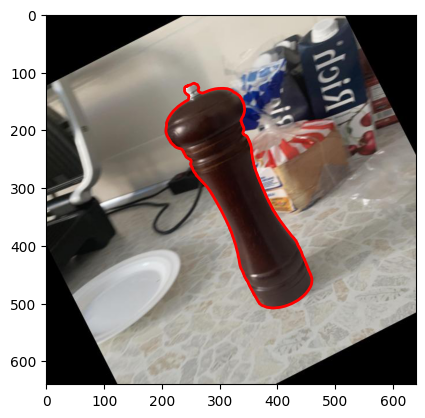

In [10]:
dataset_train = DatasetCatalog.get("train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

## Fine-tuning from a pretrained model

In [11]:
# configure `detectron2` for fine tuning from pretrained model (COCO R_50_FPN_3x)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("valid",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.TEST.EVAL_PERIOD = 100

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [12]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)
        
        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break
                
do_test(cfg, model)

[05/05 21:33:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 188MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [05/05 21:33:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 21:33:45 d2.data.datasets.coco]: Loaded 315 images in COCO format from ./amlseg-1/train/_annotations.coco.json
[05/05 21:33:45 d2.data.build]: Removed 3 images with no usable annotations. 312 images left.
[05/05 21:33:45 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   pepper   | 0            |  charger   | 186          |   pepper   | 162          |
|            |              |            |              |            |              |
|   total    | 348          |            |              |            |              |
[05/05 21:33:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


[05/05 21:33:56 d2.utils.events]:  iter: 19  total_loss: 2.287  loss_cls: 1.43  loss_box_reg: 0.1422  loss_mask: 0.6887  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.003556     lr: 4.9953e-06  max_mem: 1768M
[05/05 21:34:06 d2.utils.events]:  eta: 0:43:13  iter: 39  total_loss: 2.131  loss_cls: 1.295  loss_box_reg: 0.1392  loss_mask: 0.6767  loss_rpn_cls: 0.0116  loss_rpn_loc: 0.00489     lr: 9.9902e-06  max_mem: 1768M
[05/05 21:34:13 d2.utils.events]:  eta: 0:27:42  iter: 59  total_loss: 1.832  loss_cls: 0.9748  loss_box_reg: 0.1552  loss_mask: 0.6517  loss_rpn_cls: 0.00572  loss_rpn_loc: 0.00317     lr: 1.4985e-05  max_mem: 1768M
[05/05 21:34:20 d2.utils.events]:  eta: 0:29:37  iter: 79  total_loss: 1.462  loss_cls: 0.643  loss_box_reg: 0.1405  loss_mask: 0.6226  loss_rpn_cls: 0.01682  loss_rpn_loc: 0.003396     lr: 1.998e-05  max_mem: 1768M
WARNING [05/05 21:34:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 21:34

OrderedDict([('bbox',
              {'AP': 68.46846186719512,
               'AP50': 74.75247524752476,
               'AP75': 74.75247524752476,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 91.28503921820753,
               'AP-pepper': 80.43847241867044,
               'AP-charger': 56.49845131571981}),
             ('segm',
              {'AP': 73.93321685109687,
               'AP50': 74.75247524752476,
               'AP75': 74.75247524752476,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 98.67113181906426,
               'AP-pepper': 87.12871287128714,
               'AP-charger': 60.737720830906625})])

## Test model and show example output

In [20]:
def image_grid(imgs, rows, cols):
    # assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [17]:
len(ims)

31

[05/05 21:48:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0001499.pth ...
WARNING [05/05 21:48:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 21:48:52 d2.data.datasets.coco]: Loaded 15 images in COCO format from ./amlseg-1/test/_annotations.coco.json


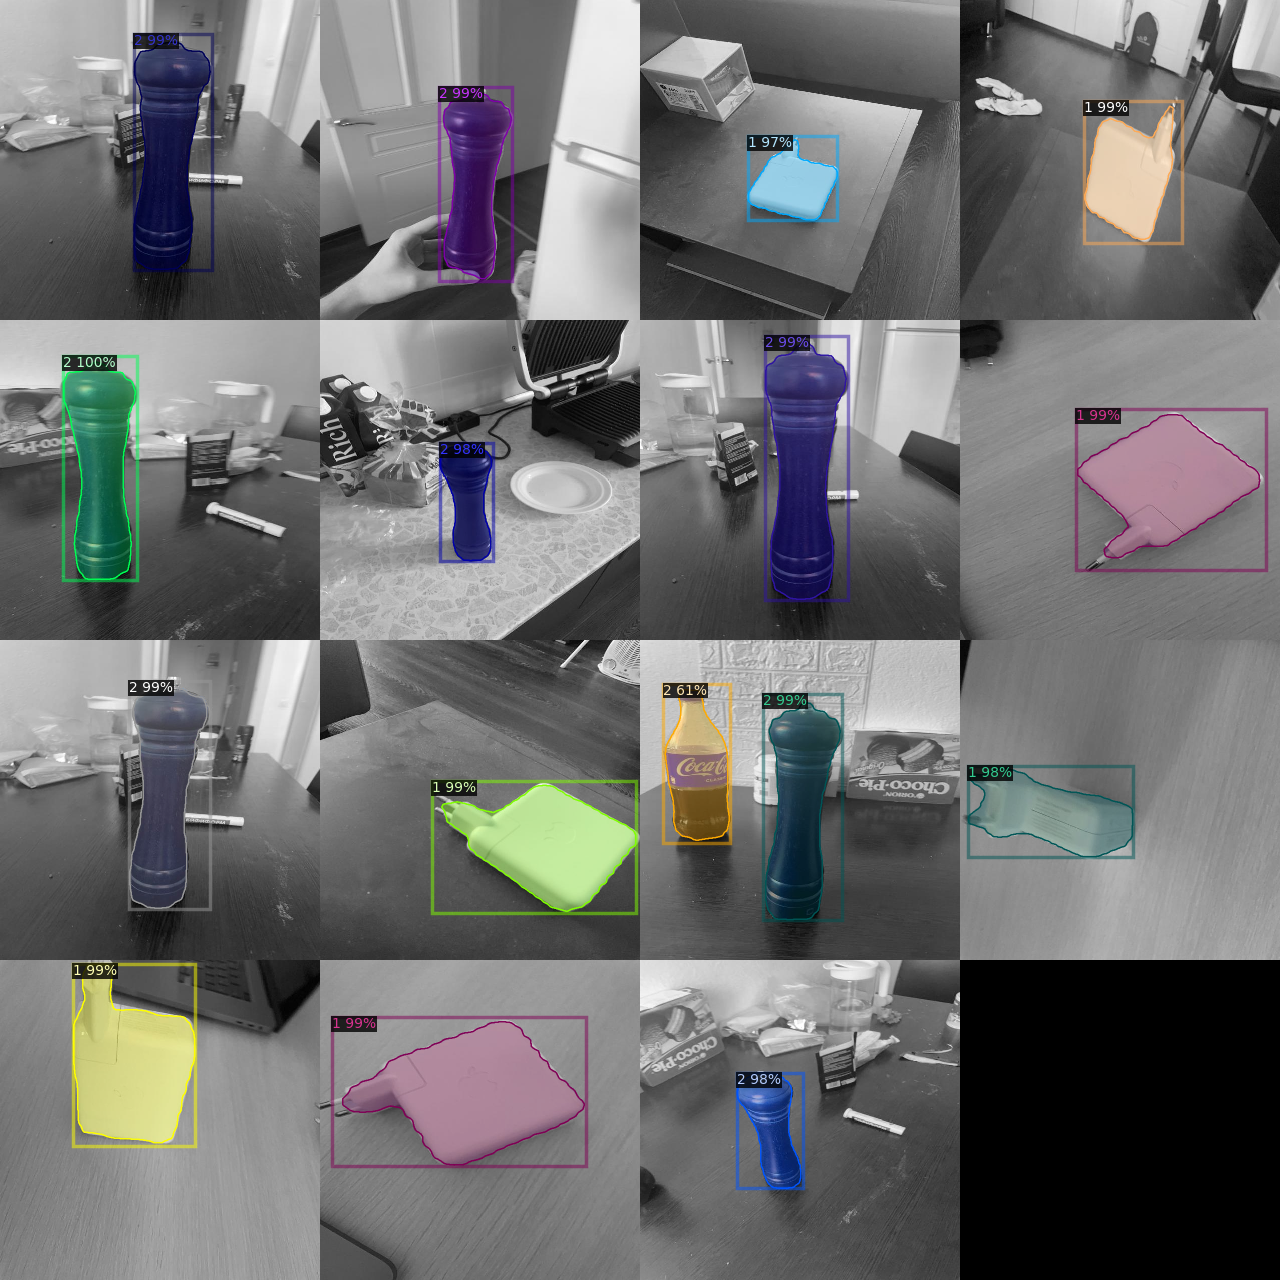

In [22]:
from IPython.display import display

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("test")
ims = []
for d in dataset_dicts:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    ims.append(im)

image_grid(ims, 4, 4)

In [25]:
cfg.DATASETS.TEST = ("test",)

do_test(cfg, model)

WARNING [05/05 21:49:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/05 21:49:51 d2.data.datasets.coco]: Loaded 15 images in COCO format from ./amlseg-1/test/_annotations.coco.json
[05/05 21:49:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 21:49:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 21:49:51 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[05/05 21:49:51 d2.data.common]: Serialized dataset takes 0.12 MiB
[05/05 21:49:51 d2.evaluation.evaluator]: Start inference on 15 batches
[05/05 21:49:53 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0093 s/iter. Inference: 0.1258 s/iter. Eval: 0.0035 s/iter. Total: 0.1386 s/iter. ETA=0:00:00
[05/05 21:49:53 d2.evaluation.eva

OrderedDict([('bbox',
              {'AP': 58.792963224893924,
               'AP50': 63.30445544554455,
               'AP75': 63.30445544554455,
               'APs': 0.0,
               'APm': nan,
               'APl': 82.91867043847242,
               'AP-pepper': 60.48267326732674,
               'AP-charger': 57.1032531824611}),
             ('segm',
              {'AP': 62.79526166902405,
               'AP50': 63.30445544554455,
               'AP75': 63.30445544554455,
               'APs': 0.0,
               'APm': nan,
               'APl': 88.88613861386139,
               'AP-pepper': 63.242574257425744,
               'AP-charger': 62.34794908062236})])